In [1]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras.layers import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_dir= r"C:\Users\hp\OneDrive\Desktop\New folder (2)\garbage\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32 
seed = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 113 files belonging to 6 classes.
Using 80 files for training.


In [4]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.4,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.cache().prefetch(tf.data.AUTOTUNE)


Found 113 files belonging to 6 classes.
Using 45 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
print("Val batches:", val_batches)
# Split the validation dataset into two equal parts:
# First half becomes the test dataset

if val_batches > 1:
    test_ds = val_ds.take(val_batches // 2)
    val_ds = val_ds.skip(val_batches // 2)
    test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)
else:
    test_ds_eval = None
    print("⚠️ Skipping test dataset creation: Not enough validation batches.")


Val batches: 2


In [6]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
6


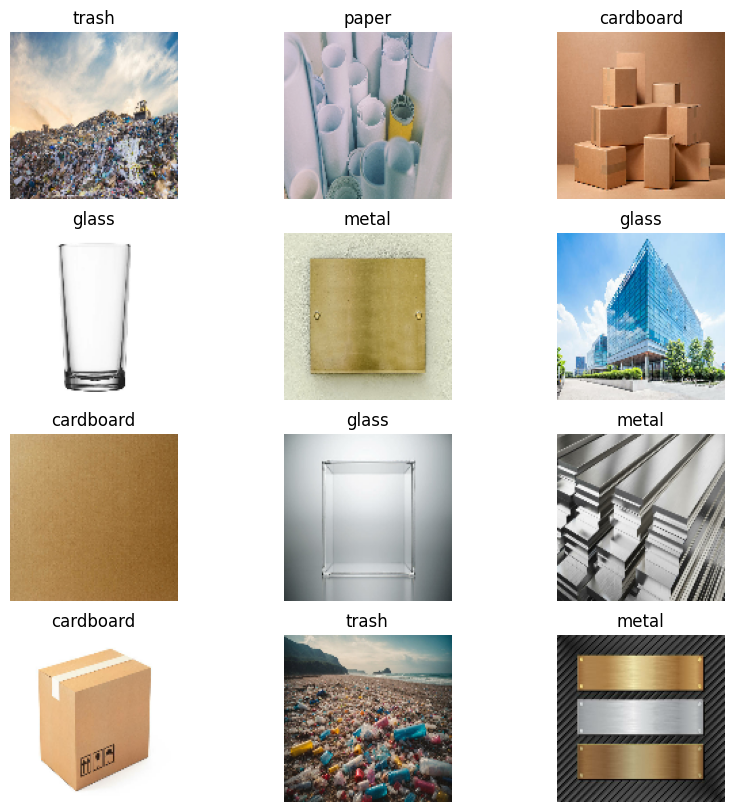

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return {name: 0.0 for name in class_names}

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()



In [10]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 21.25, 'glass': 17.5, 'metal': 16.25, 'paper': 13.75, 'plastic': 16.25, 'trash': 15.0}
{'cardboard': 7.69, 'glass': 15.38, 'metal': 15.38, 'paper': 15.38, 'plastic': 7.69, 'trash': 38.46}
{'cardboard': 9.38, 'glass': 12.5, 'metal': 18.75, 'paper': 12.5, 'plastic': 25.0, 'trash': 21.88}
{'cardboard': 14.47, 'glass': 16.44, 'metal': 15.82, 'paper': 14.57, 'plastic': 11.97, 'trash': 26.73}


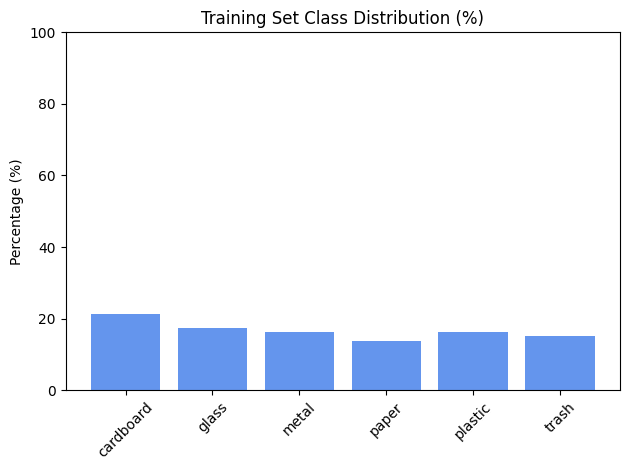

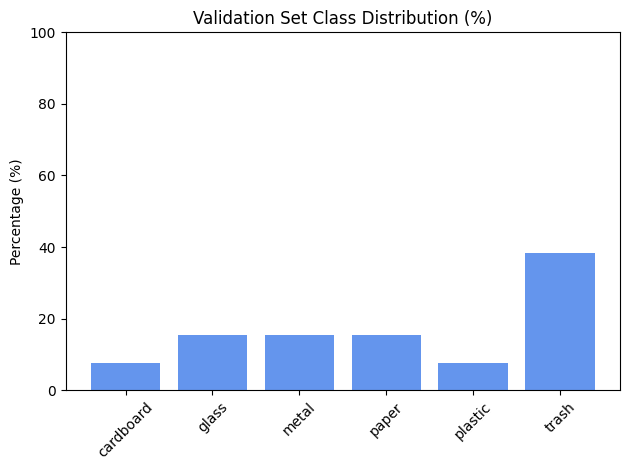

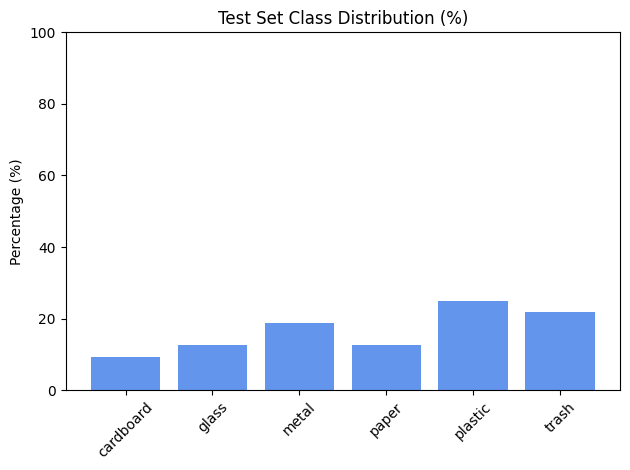

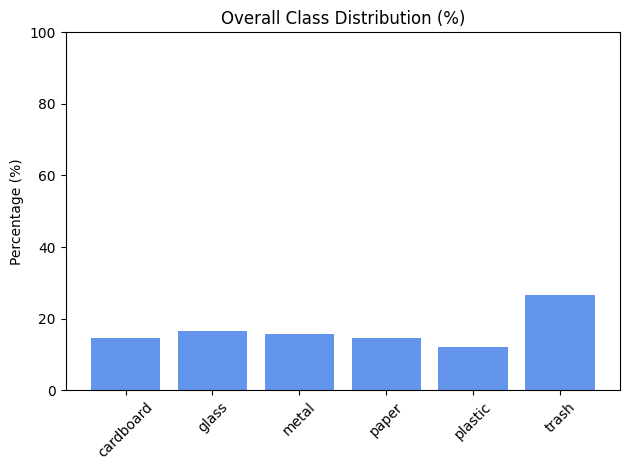

In [11]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# # Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for _, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(int(label))  # Ensure it's int

# Use only the classes that are actually present in y
present_classes = np.unique(all_labels)

# Compute class weights only for present classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=present_classes,
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights_full = {int(cls): weight for cls, weight in zip(present_classes, class_weights_array)}

print("Class weights:", class_weights)

Class weights: {0: 0.7843137254901961, 1: 0.9523809523809523, 2: 1.0256410256410255, 3: 1.2121212121212122, 4: 1.0256410256410255, 5: 1.1111111111111112}


In [13]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 17, 1: 14, 2: 13, 3: 11, 4: 13, 5: 12}
Class Weights: {0: 0.7843137254901961, 1: 0.9523809523809523, 2: 1.0256410256410255, 3: 1.2121212121212122, 4: 1.0256410256410255, 5: 1.1111111111111112}


In [14]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [15]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [16]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [17]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [19]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset
# print(class_weights)
print("Class names:", class_names)
print("Class counts from training data:")
print(class_counts)

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights_full,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

# print(class_weights)

Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class counts from training data:
{0: 17, 1: 14, 2: 13, 3: 11, 4: 13, 5: 12}
Epoch 1/15


3/3 [==============================] - 26s 2s/step - loss: 1.8857 - accuracy: 0.1500 - val_loss: 2.0640 - val_accuracy: 0.1538
Epoch 2/15
3/3 [==============================] - 2s 574ms/step - loss: 1.7394 - accuracy: 0.2875 - val_loss: 1.7320 - val_accuracy: 0.3077
Epoch 3/15
3/3 [==============================] - 2s 572ms/step - loss: 1.7087 - accuracy: 0.2875 - val_loss: 1.8025 - val_accuracy: 0.3077
Epoch 4/15
3/3 [==============================] - 2s 550ms/step - loss: 1.4845 - accuracy: 0.4500 - val_loss: 1.7011 - val_accuracy: 0.3846
Epoch 5/15
3/3 [==============================] - 2s 528ms/step - loss: 1.4233 - accuracy: 0.5000 - val_loss: 1.4503 - val_accuracy: 0.4615
Epoch 6/15
3/3 [==============================] - 2s 504ms/step - loss: 1.3414 - accuracy: 0.5875 - val_loss: 1.4703 - val_accuracy: 0.5385
Epoch 7/15

In [20]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 124, 124, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 4, 4, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 6)                 8454      
                                                                 
Total params: 8777828 (33.48 MB)
Trainable params: 797

In [21]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 124, 124, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 124, 124, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 124, 124, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 62, 62, 32)           864       ['normalizatio

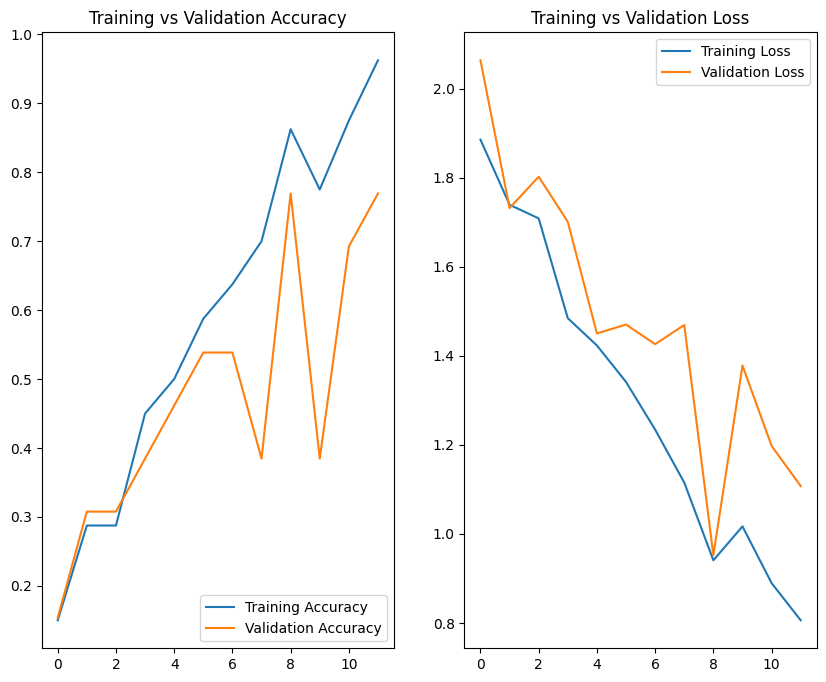

In [22]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [23]:
test_batches = tf.data.experimental.cardinality(test_ds_eval).numpy()

if test_batches > 0:
    loss, accuracy = model.evaluate(test_ds_eval)
    print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')
else:
    print("Skipping test evaluation: test_ds_eval has no data.")


# loss, accuracy = model.evaluate(test_ds_eval)
# print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

1/1 [==============================] - 0s 279ms/step - loss: 1.2834 - accuracy: 0.5000
Test accuracy is 0.5000, Test loss is 1.2834


In [24]:
if test_ds_eval:
    try:
        # Extract true labels
        y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)

        # Make predictions
        y_pred_probs = model.predict(test_ds_eval)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Compute and display metrics
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    except Exception as e:
        print("⚠️ Error during evaluation:", e)
else:
    print("⚠️ No test data available to compute predictions or metrics.")



# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


1/1 [==============================] - 2s 2s/step
Confusion Matrix:
 [[1 1 0 1 0 0]
 [0 2 1 0 0 0]
 [2 2 2 0 0 1]
 [2 0 0 2 0 0]
 [0 1 0 2 5 0]
 [0 0 1 1 1 4]]

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.20      0.33      0.25         3
       glass       0.33      0.67      0.44         3
       metal       0.50      0.29      0.36         7
       paper       0.33      0.50      0.40         4
     plastic       0.83      0.62      0.71         8
       trash       0.80      0.57      0.67         7

    accuracy                           0.50        32
   macro avg       0.50      0.50      0.47        32
weighted avg       0.58      0.50      0.52        32

1/1 [==============================] - 0s 242ms/step
[[1 1 0 1 0 0]
 [0 2 1 0 0 0]
 [2 2 2 0 0 1]
 [2 0 0 2 0 0]
 [0 1 0 2 5 0]
 [0 0 1 1 1 4]]
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       

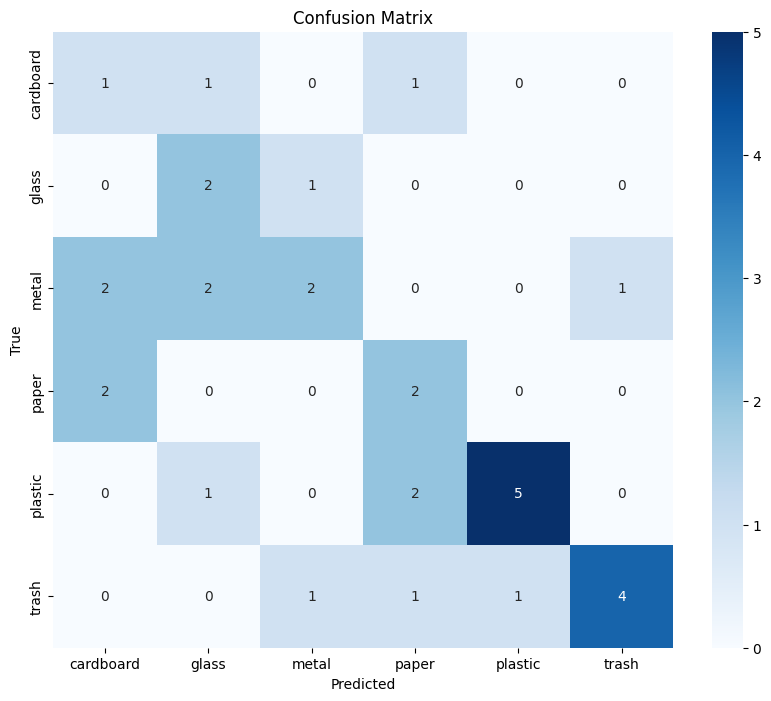

In [25]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 [==============================] - 2s 2s/step


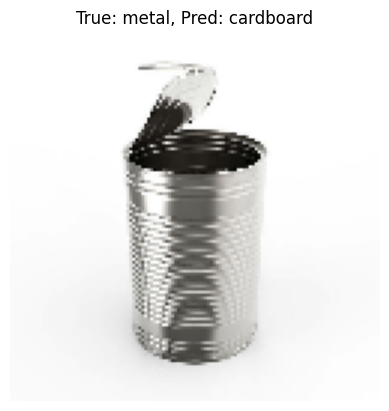

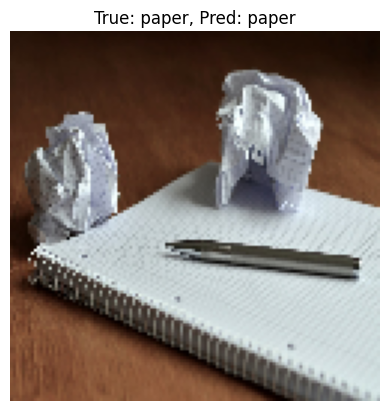

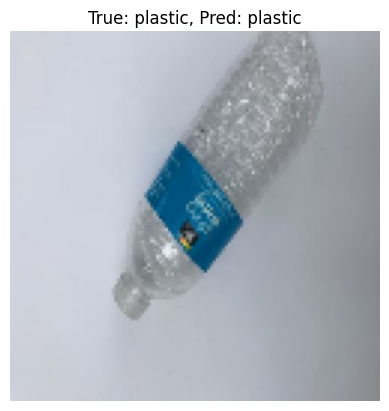

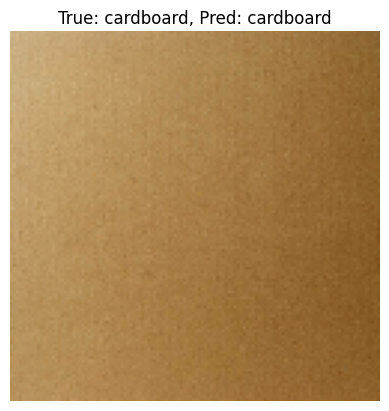

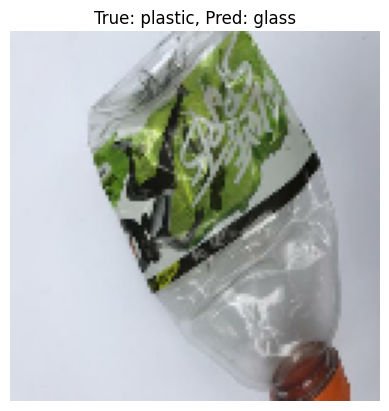

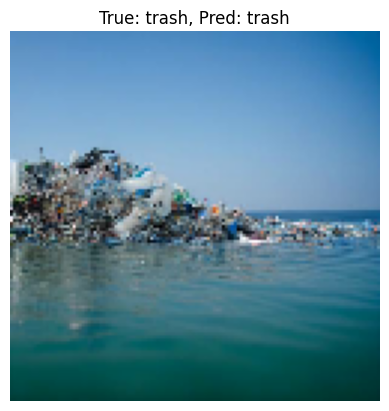

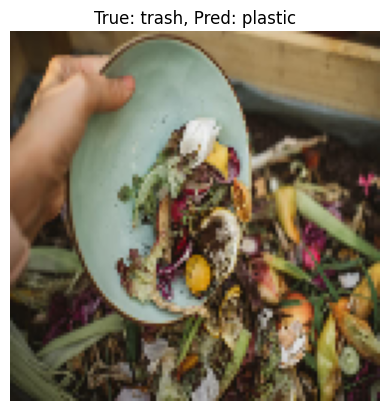

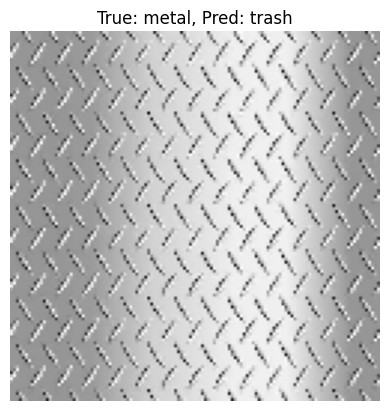

In [26]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [27]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [28]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [30]:
def classify_image(img):  
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))  
    
    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)  
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)  
    
    # Make a prediction using the trained model
    prediction = model.predict(img_array)  
    
    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)  
    
    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]  
    
    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]  
    
    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [31]:
iface = gr.Interface(  
    fn=classify_image,  # Function to classify image using the trained model  
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image  
    outputs="text"  # Outputs prediction as text  
)  

# Launch the interface  
iface.launch()  # Start the Gradio interface for user interaction  

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
